<a href="https://colab.research.google.com/github/03chrisk/PEFT-T5-on-CNN-dailynews/blob/main/Monkey.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
from huggingface_hub import notebook_login
notebook_login() #u need my token for that, ask on dms as its private

c:\Users\Christian\uni\PEFT-T5-on-CNN-dailynews\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


ImportError: The `notebook_login` function can only be used in a notebook (Jupyter or Colab) and you need the `ipywidgets` module: `pip install ipywidgets`.

In [ ]:
!pip install datasets
!pip install transformers datasets evaluate rouge_score
!pip install transformers datasets torch

In [1]:
from datasets import load_dataset

ds = load_dataset("abisee/cnn_dailymail", "3.0.0")
ds.keys()
print(ds['train'])
print(ds['test'])
print(ds['validation'])

c:\Users\Christian\uni\PEFT-T5-on-CNN-dailynews\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Dataset({
    features: ['article', 'highlights', 'id'],
    num_rows: 287113
})
Dataset({
    features: ['article', 'highlights', 'id'],
    num_rows: 11490
})
Dataset({
    features: ['article', 'highlights', 'id'],
    num_rows: 13368
})


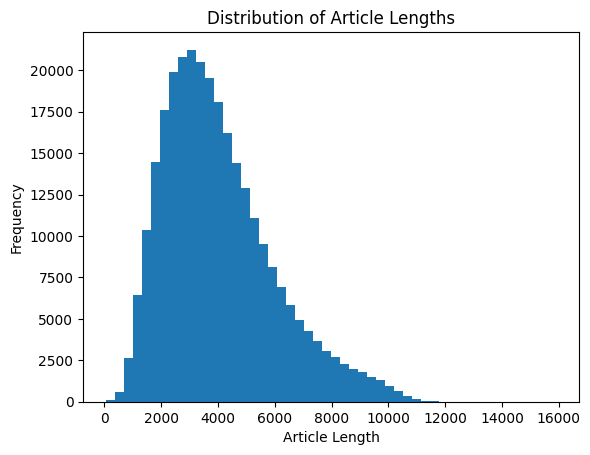

In [2]:
import matplotlib.pyplot as plt

article_lengths = [len(article) for article in ds['train']['article']]

plt.hist(article_lengths, bins=50)
plt.xlabel('Article Length')
plt.ylabel('Frequency')
plt.title('Distribution of Article Lengths')
plt.show()

In [3]:
ds['train']['article'][0]

'LONDON, England (Reuters) -- Harry Potter star Daniel Radcliffe gains access to a reported £20 million ($41.1 million) fortune as he turns 18 on Monday, but he insists the money won\'t cast a spell on him. Daniel Radcliffe as Harry Potter in "Harry Potter and the Order of the Phoenix" To the disappointment of gossip columnists around the world, the young actor says he has no plans to fritter his cash away on fast cars, drink and celebrity parties. "I don\'t plan to be one of those people who, as soon as they turn 18, suddenly buy themselves a massive sports car collection or something similar," he told an Australian interviewer earlier this month. "I don\'t think I\'ll be particularly extravagant. "The things I like buying are things that cost about 10 pounds -- books and CDs and DVDs." At 18, Radcliffe will be able to gamble in a casino, buy a drink in a pub or see the horror film "Hostel: Part II," currently six places below his number one movie on the UK box office chart. Details o

In [4]:
ds['train'][0]

{'article': 'LONDON, England (Reuters) -- Harry Potter star Daniel Radcliffe gains access to a reported £20 million ($41.1 million) fortune as he turns 18 on Monday, but he insists the money won\'t cast a spell on him. Daniel Radcliffe as Harry Potter in "Harry Potter and the Order of the Phoenix" To the disappointment of gossip columnists around the world, the young actor says he has no plans to fritter his cash away on fast cars, drink and celebrity parties. "I don\'t plan to be one of those people who, as soon as they turn 18, suddenly buy themselves a massive sports car collection or something similar," he told an Australian interviewer earlier this month. "I don\'t think I\'ll be particularly extravagant. "The things I like buying are things that cost about 10 pounds -- books and CDs and DVDs." At 18, Radcliffe will be able to gamble in a casino, buy a drink in a pub or see the horror film "Hostel: Part II," currently six places below his number one movie on the UK box office char

Some stuff from tutorial (no fine tuning)

In [5]:
from transformers import pipeline
import torch

model_name = "t5-small" # or gpt-2, facebook/barg-large-cnn, etc.
revision = "main"  # or a specific commit hash, version, or tag

# Check if GPU is available
device = 0 if torch.cuda.is_available() else -1

summarizer = pipeline("summarization", model=model_name, revision=revision, device=device)

text = "Machine learning is the study of computer algorithms that improve automatically through experience. It is seen as a part of artificial intelligence. Machine learning algorithms build a mathematical model based on sample data, known as training data, in order to make predictions or decisions without being explicitly programmed to do so."

summary = summarizer(text, max_length=50, min_length=25, do_sample=False)
print(f"Summary: {summary[0]['summary_text']}")

Summary: machine learning is the study of computer algorithms that improve automatically through experience . it is seen as a part of artificial intelligence .


Tutorial fine-tuning + hugginface guide


In [6]:
#train_dataset = ds["train"].shuffle(seed=42).select(range(100))  # Using a subset for quick fine-tuning
#test_dataset = ds["test"].shuffle(seed=42).select(range(100))
train_dataset = ds["train"].select(range(100))
test_dataset = ds["test"].select(range(100))

In [7]:
from transformers import AutoTokenizer

model_name = "google-t5/t5-small"
tokenizer = AutoTokenizer.from_pretrained(model_name)

prefix = "summarize: " #PROMPTING

def tokenize_function(examples):
    #return tokenizer(examples['article'], padding="max_length", truncation=True)
    inputs = [prefix + article for article in examples['article']]
    model_inputs = tokenizer(inputs, max_length=1024, truncation=True)

    labels = tokenizer(text_target=examples['highlights'], max_length=128, truncation=True)

    model_inputs['labels'] = labels['input_ids']
    return model_inputs

tokenized_train = train_dataset.map(tokenize_function, batched=True)
tokenized_test = test_dataset.map(tokenize_function, batched=True)



In [8]:
#print labels of tokenized_train
print(tokenized_train[0]['labels'])
print(tokenized_train[0]['input_ids'])

[8929, 16023, 2213, 4173, 6324, 12591, 15, 2347, 3996, 1755, 329, 13462, 38, 3, 88, 5050, 507, 2089, 3, 5, 5209, 7556, 845, 3, 88, 65, 150, 1390, 12, 9030, 17, 449, 112, 1723, 550, 3, 5, 6324, 12591, 15, 31, 7, 8783, 45, 166, 874, 16023, 4852, 43, 118, 1213, 16, 2019, 3069, 3, 5, 1]
[21603, 10, 301, 24796, 4170, 6, 2789, 41, 18844, 61, 1636, 8929, 16023, 2213, 4173, 6324, 12591, 15, 11391, 592, 12, 3, 9, 2196, 3996, 1755, 770, 8785, 591, 11039, 770, 61, 13462, 38, 3, 88, 5050, 507, 30, 2089, 6, 68, 3, 88, 10419, 7, 8, 540, 751, 31, 17, 4061, 3, 9, 10783, 30, 376, 5, 4173, 6324, 12591, 15, 38, 8929, 16023, 16, 96, 15537, 651, 16023, 11, 8, 5197, 13, 8, 12308, 121, 304, 8, 19142, 13, 29517, 6710, 343, 7, 300, 8, 296, 6, 8, 1021, 7556, 845, 3, 88, 65, 150, 1390, 12, 9030, 17, 449, 112, 1723, 550, 30, 1006, 2948, 6, 3281, 11, 17086, 2251, 5, 96, 196, 278, 31, 17, 515, 12, 36, 80, 13, 273, 151, 113, 6, 38, 1116, 38, 79, 919, 14985, 8247, 805, 1452, 3, 9, 3805, 2100, 443, 1232, 42, 424, 1126

In [9]:
len(tokenized_train[0]['input_ids'])  - len(tokenized_train['article'][0].split()) # no clue what that means yet

183

In [25]:
from transformers import DataCollatorForSeq2Seq

data_collator = DataCollatorForSeq2Seq(tokenizer=tokenizer, model=model_name, padding=True)

In [11]:
tokenized_train = tokenized_train.remove_columns(["highlights", "article", "id"])
tokenized_test = tokenized_test.remove_columns(["highlights", "article", "id"])
print(tokenized_test.column_names)

['input_ids', 'attention_mask', 'labels']


In [13]:
from torch.utils.data import DataLoader

# Define batch size
batch_size = 8  # Adjust as needed

# For training dataset
tokenized_train.set_format(type='torch', columns=['input_ids', 'attention_mask', 'labels'])

# Create DataLoader for training
train_dataloader = DataLoader(
    tokenized_train, 
    batch_size=batch_size, 
    shuffle=True,  # Shuffle training data
    collate_fn=data_collator  # Use the same collator for dynamic padding
)

# For testing dataset
tokenized_test.set_format(type='torch', columns=['input_ids', 'attention_mask', 'labels'])

# Create DataLoader for testing
test_dataloader = DataLoader(
    tokenized_test, 
    batch_size=batch_size, 
    shuffle=False,  # No need to shuffle for evaluation
    collate_fn=data_collator
)

In [14]:
import evaluate
rouge = evaluate.load("rouge")

In [15]:
import numpy as np

def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    decoded_preds = tokenizer.batch_decode(predictions, skip_special_tokens=True)
    labels = np.where(labels != -100, labels, tokenizer.pad_token_id)
    decoded_labels = tokenizer.batch_decode(labels, skip_special_tokens=True)

    result = rouge.compute(predictions=decoded_preds, references=decoded_labels, use_stemmer=True)

    prediction_lens = [np.count_nonzero(pred != tokenizer.pad_token_id) for pred in predictions]
    result["gen_len"] = np.mean(prediction_lens)

    return {k: round(v, 4) for k, v in result.items()}

In [16]:
from transformers import AutoModelForSeq2SeqLM, Seq2SeqTrainingArguments, Seq2SeqTrainer

model = AutoModelForSeq2SeqLM.from_pretrained(model_name)


In [17]:
from peft import LoraConfig, get_peft_model

lora_config = LoraConfig(
    r=8, 
    lora_alpha=32,  
    target_modules=["q", "v"],
    lora_dropout=0.1, 
    bias="none" 
)

# Wrap the model with LoRA configuration
model = get_peft_model(model, lora_config)


In [26]:
# Full parameter fine tuning mz bad

training_args = Seq2SeqTrainingArguments(
    output_dir="my_awesome_billsum_model",
    eval_strategy="epoch",
    learning_rate=2e-5,
    #per_device_train_batch_size=16,
    #per_device_eval_batch_size=16,
    weight_decay=0.01,
    save_total_limit=3,
    num_train_epochs=4,
    predict_with_generate=True,
    fp16=True, #change to bf16=True for XPU
    push_to_hub=False,
    remove_unused_columns=False
)

trainer = Seq2SeqTrainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_train,
    eval_dataset=tokenized_test,
    tokenizer=tokenizer,
    data_collator=data_collator,
    compute_metrics=compute_metrics,
)

trainer.train()

  0%|          | 0/52 [00:00<?, ?it/s]c:\Users\Christian\uni\PEFT-T5-on-CNN-dailynews\.venv\Lib\site-packages\transformers\data\data_collator.py:656: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\torch\csrc\utils\tensor_new.cpp:281.)
  batch["labels"] = torch.tensor(batch["labels"], dtype=torch.int64)
 25%|██▌       | 13/52 [02:30<06:08,  9.45s/it]c:\Users\Christian\uni\PEFT-T5-on-CNN-dailynews\.venv\Lib\site-packages\transformers\generation\utils.py:1220: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(















                                               
                                   
 2

{'eval_loss': 2.368753671646118, 'eval_rouge1': 0.2522, 'eval_rouge2': 0.0917, 'eval_rougeL': 0.1992, 'eval_rougeLsum': 0.1987, 'eval_gen_len': 19.0, 'eval_runtime': 103.2499, 'eval_samples_per_second': 0.969, 'eval_steps_per_second': 0.126, 'epoch': 1.0}


 50%|█████     | 26/52 [06:29<04:00,  9.24s/it]












                                               

                                         
 50%|█████     | 26/52 [08:04<04:00,  9.24s/it]



{'eval_loss': 2.3661141395568848, 'eval_rouge1': 0.2514, 'eval_rouge2': 0.0924, 'eval_rougeL': 0.1991, 'eval_rougeLsum': 0.1985, 'eval_gen_len': 19.0, 'eval_runtime': 95.2637, 'eval_samples_per_second': 1.05, 'eval_steps_per_second': 0.136, 'epoch': 2.0}


 75%|███████▌  | 39/52 [10:16<01:56,  8.97s/it]












                                               

                                         
 75%|███████▌  | 39/52 [11:51<01:56,  8.97s/it]



{'eval_loss': 2.364332914352417, 'eval_rouge1': 0.2507, 'eval_rouge2': 0.0921, 'eval_rougeL': 0.1979, 'eval_rougeLsum': 0.1969, 'eval_gen_len': 19.0, 'eval_runtime': 95.3291, 'eval_samples_per_second': 1.049, 'eval_steps_per_second': 0.136, 'epoch': 3.0}


100%|██████████| 52/52 [14:07<00:00,  9.32s/it]c:\Users\Christian\uni\PEFT-T5-on-CNN-dailynews\.venv\Lib\site-packages\transformers\generation\utils.py:1220: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(













                                               

                                         
100%|██████████| 52/52 [15:49<00:00,  9.32s/it]

                                               
100%|██████████| 52/52 [15:49<00:00, 18.26s/it]

{'eval_loss': 2.3636934757232666, 'eval_rouge1': 0.2505, 'eval_rouge2': 0.092, 'eval_rougeL': 0.1977, 'eval_rougeLsum': 0.1967, 'eval_gen_len': 19.0, 'eval_runtime': 101.3365, 'eval_samples_per_second': 0.987, 'eval_steps_per_second': 0.128, 'epoch': 4.0}
{'train_runtime': 949.5484, 'train_samples_per_second': 0.421, 'train_steps_per_second': 0.055, 'train_loss': 2.5695721552922177, 'epoch': 4.0}


TrainOutput(global_step=52, training_loss=2.5695721552922177, metrics={'train_runtime': 949.5484, 'train_samples_per_second': 0.421, 'train_steps_per_second': 0.055, 'total_flos': 108382973067264.0, 'train_loss': 2.5695721552922177, 'epoch': 4.0})

In [ ]:
#model.save_pretrained("./fine-tuned-model")
#tokenizer.save_pretrained("./fine-tuned-model")

In [59]:
from transformers import AutoModelForSeq2SeqLM, Seq2SeqTrainingArguments, Seq2SeqTrainer
from peft import LoraConfig, get_peft_model
from transformers import TrainingArguments, Trainer
from transformers import T5ForConditionalGeneration

model_name = "google-t5/t5-small"
output_dir = "./fine-tuned-model"


training_args = Seq2SeqTrainingArguments(
    output_dir="my_awesome_billsum_model",
    eval_strategy="epoch",
    per_device_train_batch_size=8,  # Adjust batch size as needed
    per_device_eval_batch_size=8,
    learning_rate=5e-5,
    num_train_epochs=3,
    weight_decay=0.01,
    logging_dir='./logs',
    logging_steps=10,
    save_steps=1000,
    push_to_hub=False,
    fp16=True,  # Enable mixed precision if using GPU
    remove_unused_columns=False  # Fix for ValueError
)

model = T5ForConditionalGeneration.from_pretrained("t5-small")

# Define LoRA config
lora_config = LoraConfig(
    r=32,  # Rank
    lora_alpha=32,
    lora_dropout=0.1,
    task_type="SEQ_2_SEQ_LM"
)

# Pass the actual model object to get_peft_model, not a string
peft_model = get_peft_model(model, lora_config)
    
peft_trainer = Trainer(
    model=peft_model,
    args=training_args,
    train_dataset=tokenized_train,
)
peft_trainer.train()

ValueError: expected sequence of length 525 at dim 1 (got 882)

In [27]:
text = "summarize: The Inflation Reduction Act lowers prescription drug costs, health care costs, and energy costs. It's the most aggressive action on tackling the climate crisis in American history, which will lift up American workers and create good-paying, union jobs across the country. It'll lower the deficit and ask the ultra-wealthy and corporations to pay their fair share. And no one making under $400,000 per year will pay a penny more in taxes."

In [48]:
# Tokenize the input string
inputs = tokenizer(text, max_length=1024, truncation=True, padding="max_length")
#print(inputs)
# Get prediction summary
with torch.no_grad():  # Disable gradient computation since we're just doing inference
    outputs = model(**inputs)

predictions = tokenizer.batch_decode(outputs.logits.argmax(dim=-1), skip_special_tokens=True)
print(predictions)

AttributeError: 'list' object has no attribute 'size'

In [36]:
from transformers import pipeline
import torch

model_name_ = 
revision = "main"  # or a specific commit hash, version, or tag

# Check if GPU is available
device = 0 if torch.cuda.is_available() else -1

summarizer = pipeline("summarization", model=model_name_, device=device)

summary = summarizer(text)#, max_length=50, min_length=25, do_sample=False)
print(f"Summary: {summary[0]['summary_text']}")

OSError: Incorrect path_or_model_id: '/c%3A/Users/Christian/uni/PEFT-T5-on-CNN-dailynews/notebooks/my_awesome_billsum_model'. Please provide either the path to a local folder or the repo_id of a model on the Hub.

In [49]:
model.save_pretrained("./fine-tuned-model")
tokenizer.save_pretrained("./fine-tuned-model")

('./fine-tuned-model\\tokenizer_config.json',
 './fine-tuned-model\\special_tokens_map.json',
 './fine-tuned-model\\spiece.model',
 './fine-tuned-model\\added_tokens.json',
 './fine-tuned-model\\tokenizer.json')